In [1]:
%load_ext autoreload
%autoreload 2

In [93]:
from corc.graph_metrics import paga, gwg, gwgmara, neb

import numpy as np
from scipy.sparse import csr_matrix
import scanpy as sc
import anndata as ad
import time
import warnings
from itertools import cycle, islice
import scipy

import matplotlib.pyplot as plt
import numpy as np
import studenttmixture

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

In [5]:
# Datasets
n_samples = 1000
seed = 30
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)

In [6]:
default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
    "dim":2,
    "n_components":15,
    "resolution":1.0,
    "resolution_leiden":1.0,
}

In [9]:
datasets = [(
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
            "resolution":0.5,
            "resolution_leiden":0.01,
        },)]

In [10]:
dataset,algo_params = datasets[0]
params = default_base.copy()
params.update(algo_params)

In [11]:
X,y = dataset

In [20]:
tmm_neb = neb.NEB(
    latent_dim=params["dim"],
    n_components=params["n_components"],
    seed=params["random_state"],
    mixture_model_type="tmm",
    n_init=1,
    optimization_iterations=50,
)
algorithm = tmm_neb

In [153]:
algorithm.fit(X)

100%|██████████| 105/105 [00:27<00:00,  3.78it/s]


In [141]:
y_pred = algorithm.predict_with_target(X,params["n_clusters"])

In [142]:
colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(max(y_pred), max(y)) + 1),
                )
            )
        )
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])

In [143]:
algorithm.adjacency_

array([[1.        , 0.72675641, 0.72675641, 0.        , 0.76894457,
        0.        , 0.72675641, 0.        , 0.        , 0.72675641,
        0.84682043, 0.        , 0.        , 0.        , 0.90398643],
       [0.72675641, 1.        , 0.83332385, 0.        , 0.72675641,
        0.        , 0.89449684, 0.        , 0.        , 0.96676151,
        0.72675641, 0.        , 0.        , 0.        , 0.72675641],
       [0.72675641, 0.83332385, 1.        , 0.        , 0.72675641,
        0.        , 0.83332385, 0.        , 0.        , 0.83332385,
        0.72675641, 0.        , 0.        , 0.        , 0.72675641],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.7447327 , 0.        , 0.7447327 , 0.80486937, 0.        ,
        0.        , 0.7447327 , 0.84092247, 0.8428975 , 0.        ],
       [0.76894457, 0.72675641, 0.72675641, 0.        , 1.        ,
        0.        , 0.72675641, 0.        , 0.        , 0.72675641,
        0.76894457, 0.        , 0.        , 

In [144]:
algorithm.raw_adjacency_

array([[ 0.        , -0.81383705, -0.81383705, -2.97843051, -0.68818253,
        -2.97843051, -0.81383705, -2.97843051, -2.97843051, -0.81383705,
        -0.45623469, -2.97843051, -2.97843051, -2.97843051, -0.28596973],
       [-0.81383705,  0.        , -0.49643332, -2.97843051, -0.81383705,
        -2.97843051, -0.31423384, -2.97843051, -2.97843051, -0.09899855,
        -0.81383705, -2.97843051, -2.97843051, -2.97843051, -0.81383705],
       [-0.81383705, -0.49643332,  0.        , -2.97843051, -0.81383705,
        -2.97843051, -0.49643332, -2.97843051, -2.97843051, -0.49643332,
        -0.81383705, -2.97843051, -2.97843051, -2.97843051, -0.81383705],
       [-2.97843051, -2.97843051, -2.97843051,  0.        , -2.97843051,
        -0.76029593, -2.97843051, -0.76029593, -0.58118302, -2.97843051,
        -2.97843051, -0.76029593, -0.47380137, -0.46791887, -2.97843051],
       [-0.68818253, -0.81383705, -0.81383705, -2.97843051,  0.        ,
        -2.97843051, -0.81383705, -2.97843051, 

In [145]:
linspace_x = np.linspace(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1, 128)
linspace_y = np.linspace(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1, 128)
XY = np.stack(np.meshgrid(linspace_x, linspace_y), -1)
tmm_probs = algorithm.mixture_model.score_samples(XY.reshape(-1, 2)).reshape(128, 128)


# algorithm.pairs_ = [(5,i) for i in range(15)]
algorithm.pairs_ = [(2,5)]

In [146]:
np.argmin(algorithm.logprobs_[(5,7)])

Array(527, dtype=int32)

In [147]:
len(algorithm.logprobs_[(5,7)])

1024

In [148]:
algorithm.centers_[5]

array([-0.94094511,  0.3016588 ])

In [149]:
algorithm.paths_[(5,7)][536]

array([-0.7290151 ,  0.66026133], dtype=float32)

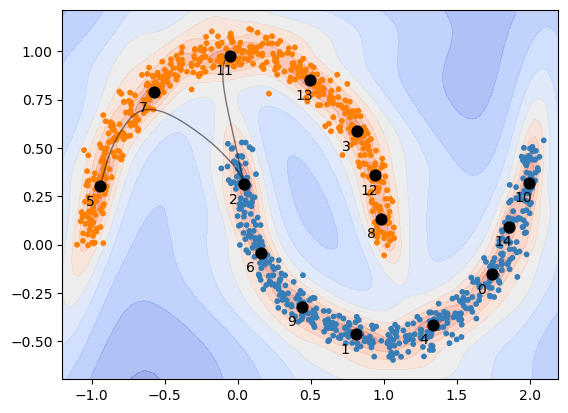

In [163]:
plt.contourf(linspace_x, linspace_y, tmm_probs, levels=10, cmap="coolwarm", alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
for i, location in enumerate(algorithm.centers_):
    plt.annotate(f"{i}", xy=location-0.1, color="black")
    
algorithm.pairs_ = [(2,5),(2,11)]

algorithm.plot_graph()

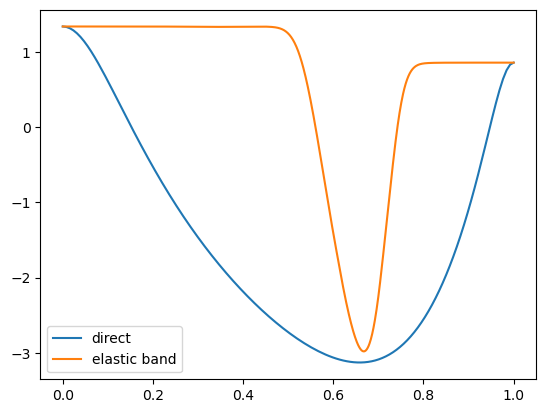

In [155]:
i=2
j=11
direct_x = np.linspace(0, 1, num=128)[..., None]
ms = (1 - direct_x) * algorithm.centers_[i] + direct_x * algorithm.centers_[j]
direct_y = algorithm.mixture_model.score_samples(ms)
plt.plot(direct_x[:, 0], direct_y, label="direct")

# and the nudged elastic band
plt.plot(algorithm.temps_[(i, j)], algorithm.logprobs_[(i, j)], label="elastic band")
plt.legend()

In [154]:
np.diff(algorithm.paths_[(2,11)])

array([[0.26989108],
       [0.26987383],
       [0.26985657],
       ...,
       [1.0291227 ],
       [1.0291167 ],
       [1.0291109 ]], dtype=float32)

In [157]:
path = algorithm.paths_[(2,11)]

(1024, 2)

In [159]:
path[650:700]

array([[-0.0505756 ,  0.6385542 ],
       [-0.05159605,  0.6420309 ],
       [-0.05261529,  0.6455117 ],
       [-0.05363299,  0.6489961 ],
       [-0.0546488 ,  0.6524837 ],
       [-0.05566239,  0.65597415],
       [-0.05667341,  0.6594669 ],
       [-0.05768153,  0.66296166],
       [-0.05868638,  0.66645795],
       [-0.05968764,  0.6699553 ],
       [-0.06068496,  0.6734535 ],
       [-0.06167798,  0.67695194],
       [-0.06266636,  0.6804503 ],
       [-0.06364976,  0.6839483 ],
       [-0.06462783,  0.68744534],
       [-0.06560022,  0.69094115],
       [-0.0665666 ,  0.6944353 ],
       [-0.06752664,  0.6979274 ],
       [-0.06847997,  0.70141715],
       [-0.06942626,  0.704904  ],
       [-0.07036513,  0.70838755],
       [-0.07129618,  0.71186715],
       [-0.07221898,  0.7153421 ],
       [-0.0731331 ,  0.71881145],
       [-0.07403811,  0.72227407],
       [-0.07493367,  0.7257289 ],
       [-0.07581943,  0.7291751 ],
       [-0.0766951 ,  0.73261166],
       [-0.07756037,

In [160]:
filtered_path = scipy.signal.savgol_filter(path,50,1,axis=0)

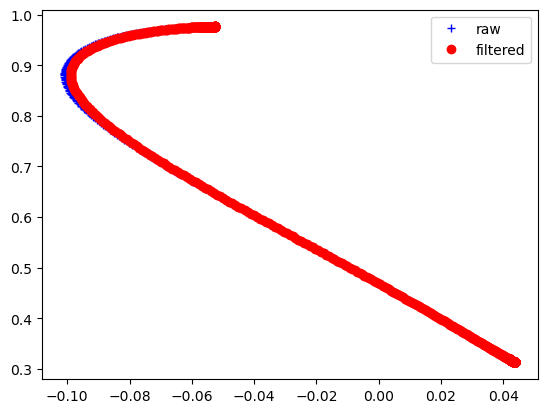

In [161]:
plt.plot(path[:,0],path[:,1],'b+', label="raw")
plt.plot(filtered_path[:,0],filtered_path[:,1], 'ro', label="filtered", )
plt.legend()